# Living life on the edge; The green taxis of NYC
![](http://www.nyc.gov/html/tlc/images/features/fi_passenger_information_shl_passenger.jpg)

![](http://www.nyc.gov/html/tlc/images/features/map_service_area.png)
#### Boro taxis are taxis in New York City that are allowed to pick up passengers (street hails or calls) in outer boroughs (excluding John F. Kennedy International Airport and LaGuardia Airport unless arranged in advance) and in Manhattan above East 96th and West 110th Streets. The color of boro taxis is apple green in contrast to the traditional yellow taxis in New York City.

## 1. Exploratory Data Analysis
## 2. Motivation for feature selection and feature engineering
## 3. Checking whether the preconditions for linear regression have been met
## 4. Modelling for taxi fare
## 5. Evaluation of model's strengths and weaknesses

## 1. Exploratory Data Analysis

In [77]:
import pandas as pd
import numpy as np 
from scipy import stats
from numpy import arange,array,ones

import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from pylab import plot,show
from random import sample

In [78]:
import plotly
from plotly.graph_objs import *
from plotly.offline import iplot, init_notebook_mode
import plotly.plotly as py
import plotly.tools as tls
import plotly.plotly as py
import plotly.graph_objs as go

import cufflinks as cf 

init_notebook_mode()
cf.go_offline()

dims = (980,800)

In [79]:
df = pd.read_csv('../data/clean_green_taxi_data.csv')

In [80]:
pd.options.display.max_columns = 50

### Inspecting data types and missing data 

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210811 entries, 0 to 1210810
Data columns (total 49 columns):
pickup_datetime                  1210811 non-null object
dropoff_datetime                 1210811 non-null object
rate_code                        1210811 non-null int64
dropoff_latitude                 1210811 non-null float64
passenger_count                  1210811 non-null int64
trip_distance                    1210811 non-null float64
fare_amount                      1210811 non-null float64
extra                            1210811 non-null float64
mta_tax                          1210811 non-null float64
tip_amount                       1210811 non-null float64
tolls_amount                     1210811 non-null float64
total_amount                     1210811 non-null float64
pickup_longitude                 1210811 non-null float64
pickup_latitude                  1210811 non-null float64
dropoff_longitude                1210811 non-null float64
borough                

In [82]:
# change column headings to lower case.
df.columns = map(str.lower, df.columns)

### Dropping some data

In [83]:
delete = ["pickup_datetime", "dropoff_datetime", "pickup_longitude", "dropoff_longitude", "pickup_latitude", 
         "dropoff_latitude"]
df.drop(df[delete], axis=1, inplace=True)

In [84]:
df["borough"].fillna(value=0, inplace=True)
df["dropoff_borough"].fillna(value=0, inplace=True)

df = df[df["borough"] !=0]
df = df[df["dropoff_borough"] !=0]

In [85]:
df = df[df['passenger_count'] > 0]
df = df[df['fare_amount'] > 0 ]
df = df[df['trip_distance'] > 0 ]

In [86]:
from datetime import datetime
df['trip_duration'] = pd.to_timedelta(df['trip_duration'])

In [87]:
df['trip_duration'] = [x.total_seconds()/60.0 for x in df['trip_duration']]

In [88]:
df = df[df["trip_duration"] > 0]
df = df[df["trip_duration"] <700]

In [89]:
df.head(3)

rate_code  passenger_count  trip_distance  fare_amount  extra  mta_tax  \
0          1                1           0.50          4.0    0.0      0.5   
1          1                5          14.16         52.5    0.5      0.5   
2          1                1           0.60          5.0    0.0      0.5   

   tip_amount  tolls_amount  total_amount    borough dropoff_borough  \
0         0.0           0.0           4.5  Manhattan       Manhattan   
1         0.0           0.0          53.5   Brooklyn        Brooklyn   
2         0.0           0.0           5.5  Manhattan       Manhattan   

  pickup_date pickup_time dropoff_date dropoff_time  pickup_weekday  \
0  2013-12-06    12:11:05   2013-12-06     12:14:06               4   
1  2013-11-23    01:31:07   2013-11-23     02:36:01               5   
2  2013-12-13    10:26:02   2013-12-13     10:30:26               4   

   dropoff_weekday  pickup_time_hour  trip_duration  rate_code_1  rate_code_2  \
0                4                12       3.016667          1.0          0.0   
1                5                 1      64.900000          1.0          0.0   
2                4                10       4.400000          1.0          0.0   

   rate_code_3  rate_code_4  rate_code_5  rate_code_6  rate_code_99  monday  \
0          0.0          0.0          0.0          0.0           0.0     0.0   
1          0.0          0.0          0.0          0.0           0.0     0.0   
2          0.0          0.0          0.0          0.0           0.0     0.0   

   tuesday  wednesday  thursday  friday  saturday  sunday  \
0      0.0        0.0       0.0     1.0       0.0     0.0   
1      0.0        0.0       0.0     0.0       1.0     0.0   
2      0.0        0.0       0.0     1.0       0.0     0.0   

   dropoff_borough_bronx  dropoff_borough_brooklyn  dropoff_borough_manhattan  \
0                    0.0                       0.0                        1.0   
1                    0.0                       1.0                        0.0   
2                    0.0                       0.0                        1.0   

   dropoff_borough_queens  dropoff_borough_staten island  \
0                     0.0                            0.0   
1                     0.0                            0.0   
2                     0.0                            0.0   

   pickup_borough_bronx  pickup_borough_brooklyn  pickup_borough_manhattan  \
0                   0.0                      0.0                       1.0   
1                   0.0                      1.0                       0.0   
2                   0.0                      0.0                       1.0   

   pickup_borough_queens  pickup_borough_staten island  
0                    0.0                           0.0  
1                    0.0                           0.0  
2                    0.0                           0.0

In [90]:
df["same_borough"] = df["borough"] == df["dropoff_borough"] 
df["same_borough"].value_counts()

True     944643
False    215440
Name: same_borough, dtype: int64

In [91]:
pd.crosstab(df["borough"], df["dropoff_borough"])

dropoff_borough  Bronx  Brooklyn  Manhattan  Queens  Staten Island
borough                                                           
Bronx            50268       175      22870     705              2
Brooklyn           192    133666      48083   10882             66
Manhattan        37580      5214     445330   20591             15
Queens            1637     19007      48380  315220             34
Staten Island        0         3          2       2            159

In [92]:
def timeofday(hours):
    if hours <= 4:
        return "midnight"
    elif hours <= 8:
        return "morning"
    elif hours <= 12:
        return "noon"
    elif hours <= 16:
        return "afternoon"
    elif hours <= 20:
        return "evening"
    else: return "night"
    
df["time"] = df["pickup_time_hour"].apply(timeofday)

### Setting training subset

In [93]:
#Not using this one as not a fixed sample
#train = df.sample(frac=0.01)
#train = train.sort()

In [94]:
#Setting Training Set (FIXED)
def shuffle(df):
    index = list(df.index)
    rng = np.random.RandomState(1)
    rng.shuffle(index)
    train = df.ix[index][:10000]
    return train

train = shuffle(df)

## Univariate analysis

In [95]:
train['trip_duration'].describe()

count    10000.000000
mean        12.790130
std         12.827073
min          0.033333
25%          6.116667
50%          9.850000
75%         16.450000
max        663.683333
Name: trip_duration, dtype: float64

In [21]:
chart = train['trip_duration']
chart.iplot(kind="histogram", subplots=True, bins = 100, dimensions = (800,500), title = 'Duration of the trip in minutes')

In [25]:
display = ['pickup_time_hour', 'passenger_count', "pickup_weekday", 'trip_distance','borough', 'dropoff_borough']
chart = train[display]
chart.iplot(kind="histogram", subplots=True, dimensions = (980,600))

In [26]:
chart = train['time']
chart.iplot(kind="histogram", subplots=True, bins = 100, dimensions = (800,500), title = 'Time of day of the trip')

In [27]:
chart1 = train['rate_code']
chart1.iplot(kind="histogram", subplots=True, bins = 12, dimensions = (800,500), title = 'Frequency of the rate codes')

### Conclusion of univariate analysis:
#### 1. Trip distance was unimodal with a slight skew to the right. The peak occurs around 1km. There was some zero data so we decided to remove this from our data set.
#### 2. Passenger count was unimodal with a slight skew to the right. The most common number of passengers was 1. There was some zero data so we decided to remove this from our data set. This could have been real taxi rides (like a courier) but we decided to focus on modelling taxi rides transporting passengers. There was also data with large passenger numbers (>5) which is possible as there are larger vehicles available.
#### 3. Pick up time (sorted by hour) was bimodal which represented the two rush hour times. The first one occured at 9am and the second (larger) one occured at 6pm.
#### 4. We also sorted the pick up time into 4 hour slots and this showed peaks in frequency in the afternoon and evening with the lowest frequency of pick ups occuring in the morning.
#### 5. Looking at trips organised by day of the week showed peaks on Friday and Saturday as you would expect but also on Tuesday.
#### 6. Rate code shows that rate 1 is by far the most frequent rate used.
Rate 1 – Standard City Rate
Rate 2 – JFK Airport
Rate 3 – Newark Airport
Rate 4 – Out of City Rate to Nassau or Westchester
Rate 5 – Out of City Negotiated Flat Rate
Rate 6 – Group Rate
#### 7. Boroughs showed most taxi journeys started and finished in Manhattan. Interestingly there were no journeys that started in Staten Island.
#### 8. Trip duration was unimodal with a slight skew to the right. There peak occurs around 10 minutes. There was some zero data so we decided to remove this from our data set. There were also some trips that seemed to occur for 23 hours or negative time but this is probably due to day light saving hours so we removed this data too.

## Bivariate analysis

### Checking for correlation between features:

In [28]:
cols_corr = ['passenger_count','trip_distance','pickup_time_hour', 'trip_duration', 'rate_code_1', 'rate_code_2',
      'rate_code_3', 'rate_code_4', 'rate_code_5', 'rate_code_6', 'rate_code_99', 'monday', 'tuesday', 'wednesday',
      'thursday', 'friday', 'saturday', 'sunday','pickup_borough_bronx', 'pickup_borough_brooklyn', 'pickup_borough_manhattan',
      'pickup_borough_queens', 'pickup_borough_staten island']

`%matplotlib` prevents importing * from pylab and numpy
/home/vagrant/.anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Populating the interactive namespace from numpy and matplotlib


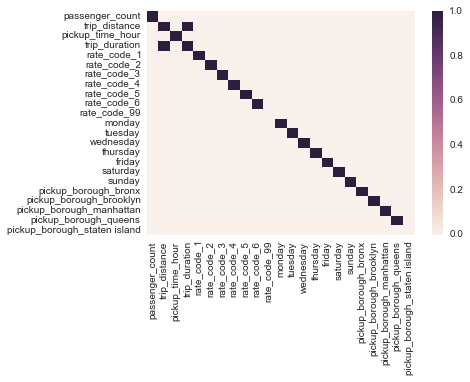

In [29]:
%pylab inline
sns.heatmap(train[cols_corr].corr() > 0.55)

#### No correlation between features. Heat map shows a very weak correlation between trip distance and trip duration but our graph shows the correlation. Distortion due to outliers.

In [30]:
# The trip distance as a function of trip duration, should we drop duration?
traces = []

trace = Scatter(**{
        'x': train['trip_duration'],
        'y': train['trip_distance'],
        'name': "trip duration",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The trip distance as a function of trip duration',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'xaxis' : {'title': 'Duration'},
    'yaxis' : {'title': 'Distance'},
    'width': 980,
    'height': 600,
})

iplot({'data': traces, 'layout': layout})

In [31]:
# The trip distance as a function of rate code, are they correlated?
traces = []

trace = Scatter(**{
        'x': train['rate_code'],
        'y': train['trip_distance'],
        'name': "rate_code",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The trip distance as a function of rate code',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'xaxis' : {'title': 'Rate code'},
    'yaxis' : {'title': 'Distance'},
    'width': 980,
    'height': 600,
})

iplot({'data': traces, 'layout': layout})

In [32]:
# The taxi fare as a function of trip duration. Outliers!
chart = train.sort_values(by = 'trip_duration')
xchart = chart['trip_duration']
ychart = chart['fare_amount']

traces = []

trace = Scatter(**{
        'x': xchart,
        'y': ychart,
        'name': "trip duration",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of trip duration',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'Duration'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

In [33]:
# The taxi fare as a function of trip distance. 
#I think this is a much better correlation and doesn't have the outliers that duration has
chart = train.sort_values(by = 'trip_distance')
xchart = chart['trip_distance']
ychart = chart['fare_amount']

traces = []

trace = Scatter(**{
        'x': xchart,
        'y': ychart,
        'name': "trip distance",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of trip distance',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'Distance'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

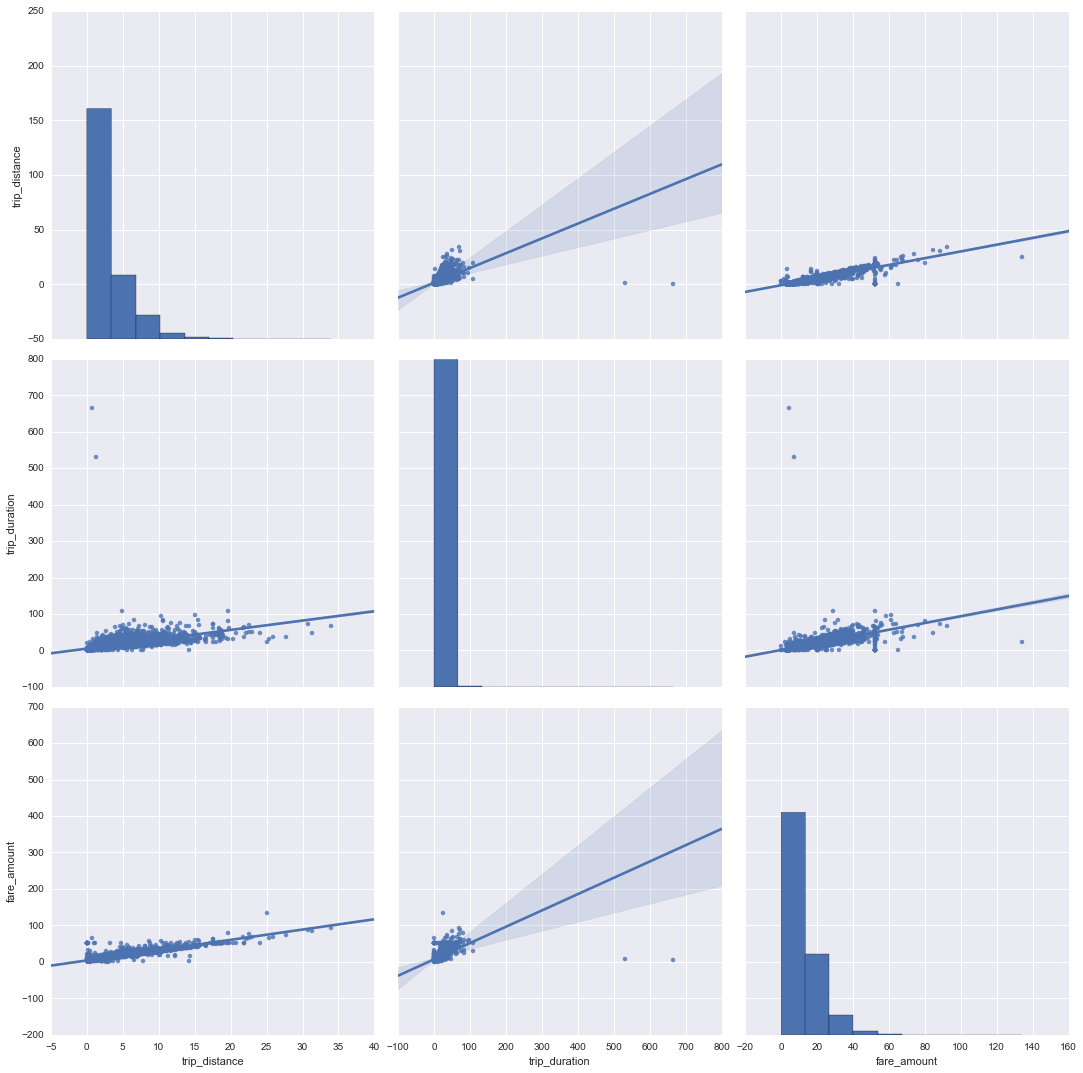

In [34]:
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["trip_duration"] = train["trip_duration"]
chart["fare_amount"] = train["fare_amount"]

chart.sort_values(by=["trip_distance"], inplace=True)

sns.pairplot(chart, kind="reg", size=5)

In [35]:
# graph to show different polynomial fits for rate as a function of distance

Xchart = xchart[:, np.newaxis]

models = []

for degree in range(1,6):
    
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(Xchart, ychart)
    
    models.append(model)
    
    trace = Scatter(**{
            'x': Xchart.flatten().tolist(),
            'y': model.predict(Xchart),
            'name': "degree {}".format(degree),
            'type': 'scatter',
            'line':dict(
                shape='spline'
            )
        })
    
    traces.append(trace)
    
iplot({'data': traces, 'layout': layout})

In [36]:
# scores for different polynomial fits for rate as a function of distance

Xchart = xchart[:, np.newaxis]

for degree in range(1,11):
    
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(Xchart, ychart)
    print degree,(model.score(Xchart, ychart))

1 0.871953944006
2 0.873704798198
3 0.87435350949
4 0.874366249352
5 0.875023084676
6 0.875427484764
7 0.875777381805
8 0.877032269273
9 0.877593833124
10 0.878088370139


In [37]:
# Comparing polynomial and distance sqaured models
from patsy import dmatrices, dmatrix
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["fare_amount"] = train["fare_amount"]
chart.sort_values(by=["trip_distance"], inplace=True)

distance = chart.trip_distance.values
fare = chart.fare_amount.values
y = fare

In [38]:
distance_poly1 = dmatrix('distance', chart)

# Only Speed^2
distance_sq = dmatrix('np.power(distance,2)', chart)

# Speed + Speed^2
distance_poly2 = dmatrix('distance + np.power(distance,2)')

In [39]:
Xs = [distance_poly1, distance_sq, distance_poly2]

In [40]:
import statsmodels.api as sm
distance_poly1_pred = sm.OLS(y, distance_poly1).fit().predict()
distance_sq_pred = sm.OLS(y, distance_sq).fit().predict()
distance_poly2_pred = sm.OLS(y, distance_poly2).fit().predict()

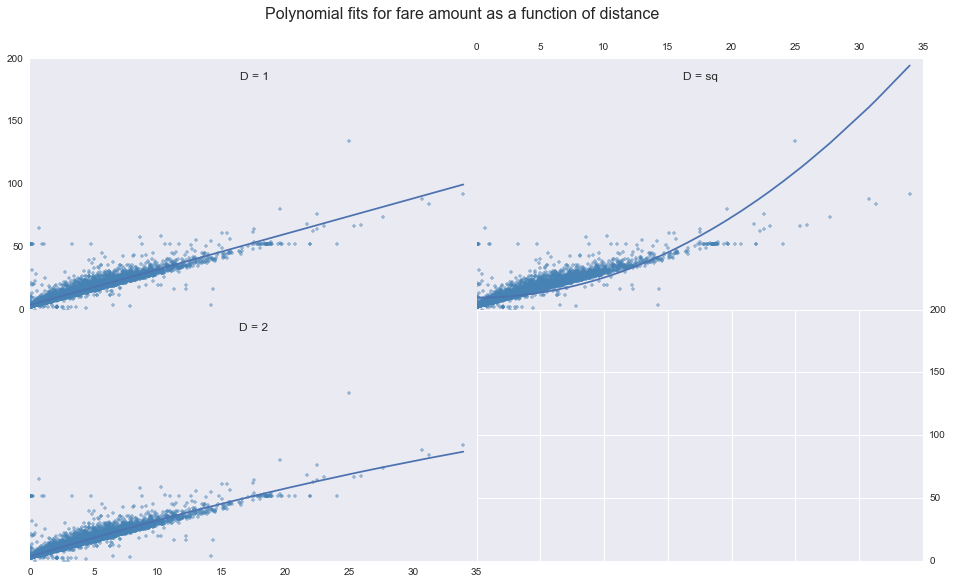

In [41]:
import matplotlib.pyplot as plt

plt.figure()

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize=(16,9))
fig.subplots_adjust(hspace = 0.0, wspace = 0.0)
fig.suptitle('Polynomial fits for fare amount as a function of distance', fontsize = 16.0)

# Iterate through panels (a), model predictions (p), and the polynomial 
# degree of the model (d). Plot the data, the predictions, and label
# the graph to indicate the degree used.
preds = [distance_poly1_pred, distance_sq_pred, distance_poly2_pred]
orders = ['1', 'sq', '2']

for a, p, d in zip(ax.ravel(), preds, orders):
    a.plot(chart.trip_distance.values, chart.fare_amount.values, '.', color = 'steelblue', alpha = 0.5)
    a.plot(chart.trip_distance.values, p)
    a.text(.5, .95, 'D = ' + d, fontsize = 12,
           verticalalignment = 'top',
           horizontalalignment = 'center',
           transform = a.transAxes)
    a.grid()
    
# Alternate axes that have tick labels to avoid overlap.
plt.setp(fig.axes[2].get_yaxis().get_ticklabels(), visible = False)
plt.setp(fig.axes[3].get_yaxis(), ticks_position = 'right')   
plt.setp(fig.axes[1].get_xaxis(), ticks_position = 'top')
plt.setp(fig.axes[3].get_xaxis().get_ticklabels(), visible = False);

In [42]:
# scores for different polynomial fits and squared fit for rate as a function of distance
def square(x):
    return x**2

xsq = xchart.apply(square)

Xchart = xchart[:, np.newaxis]
Xsq = xsq[:, np.newaxis]

for degree in range(1,3):
    
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(Xchart, ychart)
    print degree,(model.score(Xchart, ychart))

model.fit(Xsq, ychart)
print 'squared',(model.score(Xsq, ychart))

1 0.871953944006
2 0.873704798198
squared 0.7571102992


In [43]:
# The taxi fare as a function of passenger count. 
chartp = train.sort_values(by = 'passenger_count')
xchartp = chartp['passenger_count']
ychartp = chartp['fare_amount']

traces = []

trace = Scatter (**{
        'x': xchartp,
        'y': ychartp,
        'name': "passenger_count",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of passenger number',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'Number of passengers'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

In [44]:
# The taxi fare as a function of rate code. 
chartr = train.sort_values(by = 'rate_code')
xchartr = chartr['rate_code']
ychartr = chartr['fare_amount']

traces = []

trace = Scatter (**{
        'x': xchartr,
        'y': ychartr,
        'name': "rate_code",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of rate code',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'Rate code'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

In [45]:
# The taxi fare as a function of borough. 
chartb = train.sort_values(by = 'borough')
xchartb = chartb['borough']
ychartb = chartb['fare_amount']

traces = []

trace = Scatter (**{
        'x': xchartb,
        'y': ychartb,
        'name': "borough",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of borough',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'borough'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

In [46]:
# The taxi fare as a function of pick up time. 
chart_pu = train.sort_values(by = 'pickup_time_hour')
xchart_pu = chart_pu['pickup_time_hour']
ychart_pu = chart_pu['fare_amount']

traces = []

trace = Scatter (**{
        'x': xchart_pu,
        'y': ychart_pu,
        'name': "pickup_time_hour",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of pickup time',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'pickup time'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

In [47]:
# The taxi fare as a function of pick up day of the week. 
chart_w = train.sort_values(by = 'pickup_weekday')
xchart_w = chart_w['pickup_weekday']
ychart_w = chart_w['fare_amount']

traces = []

trace = Scatter (**{
        'x': xchart_w,
        'y': ychart_w,
        'name': "pickup_weekday",
        'mode': 'markers'
    })
traces.append(trace)

layout =  Layout(**{
    'title': 'The taxi fare as a function of pickup day of the week',
    'legend': dict(
        x=0.1,
        y=0.1
    ),

    'width': 980,
    'height': 600,
    'xaxis' : {'title': 'pickup day of the week'},
    'yaxis' : {'title': 'Fare'},
})

iplot({'data': traces, 'layout': layout})

### Seaborn graphs

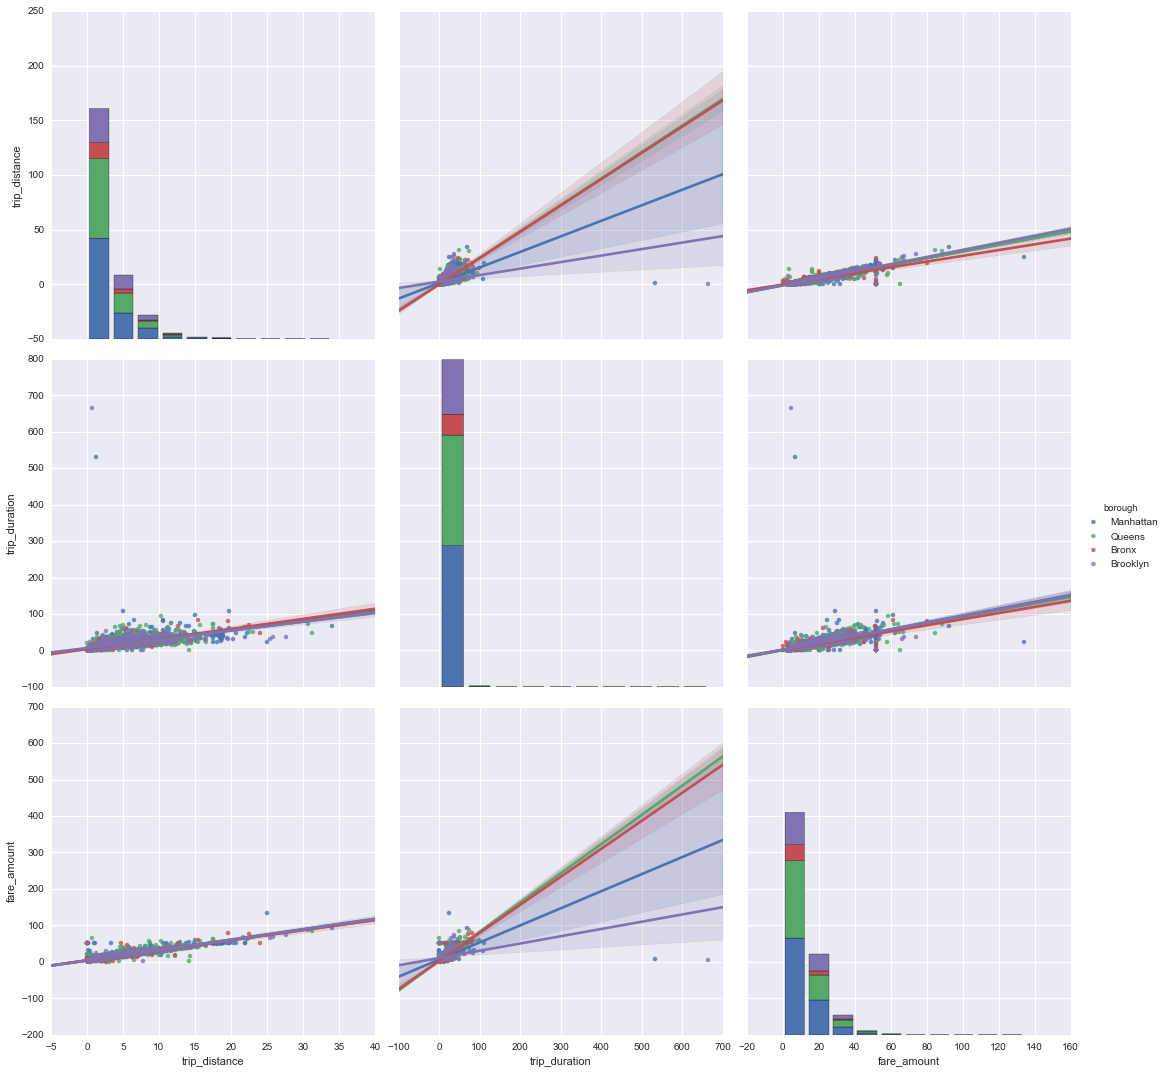

In [48]:
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["trip_duration"] = train["trip_duration"]
chart["borough"] = train["borough"]
chart["fare_amount"] = train["fare_amount"]

chart.sort_values(by=["trip_distance"], inplace=True)

sns.pairplot(chart, kind="reg", size=5, hue="borough")

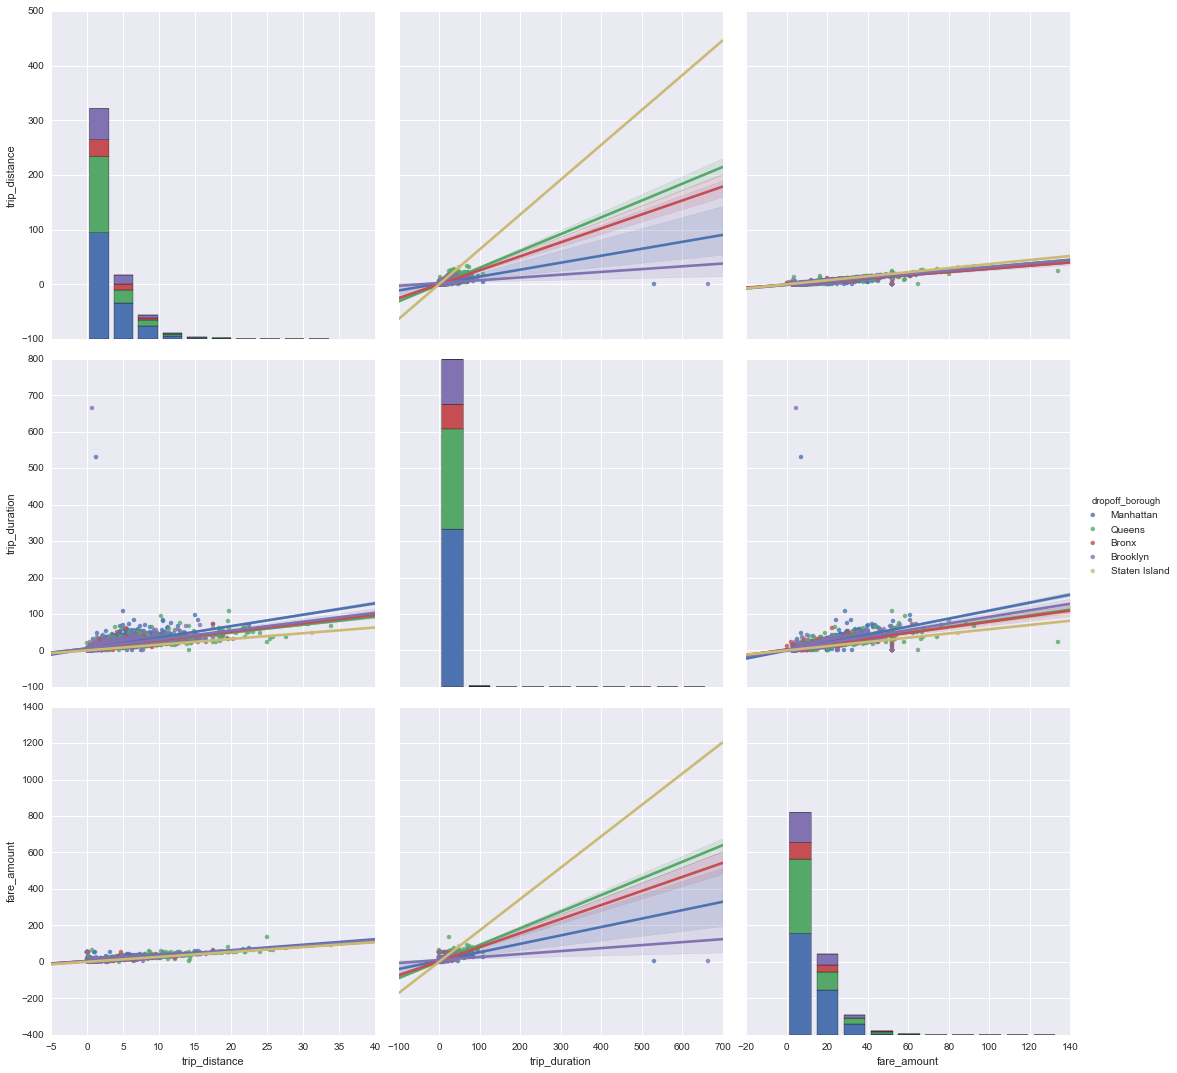

In [49]:
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["trip_duration"] = train["trip_duration"]
chart["dropoff_borough"] = train["dropoff_borough"]
chart["fare_amount"] = train["fare_amount"]

chart.sort_values(by=["trip_distance"], inplace=True)

sns.pairplot(chart, kind="reg", size=5, hue="dropoff_borough")

In [50]:
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["trip_duration"] = train["trip_duration"]
chart["same_borough"] = train["same_borough"]
chart["fare_amount"] = train["fare_amount"]

chart.sort_values(by=["trip_distance"], inplace=True)

sns.pairplot(chart, kind="reg", size=5, hue="same_borough")

KeyError: 'same_borough'

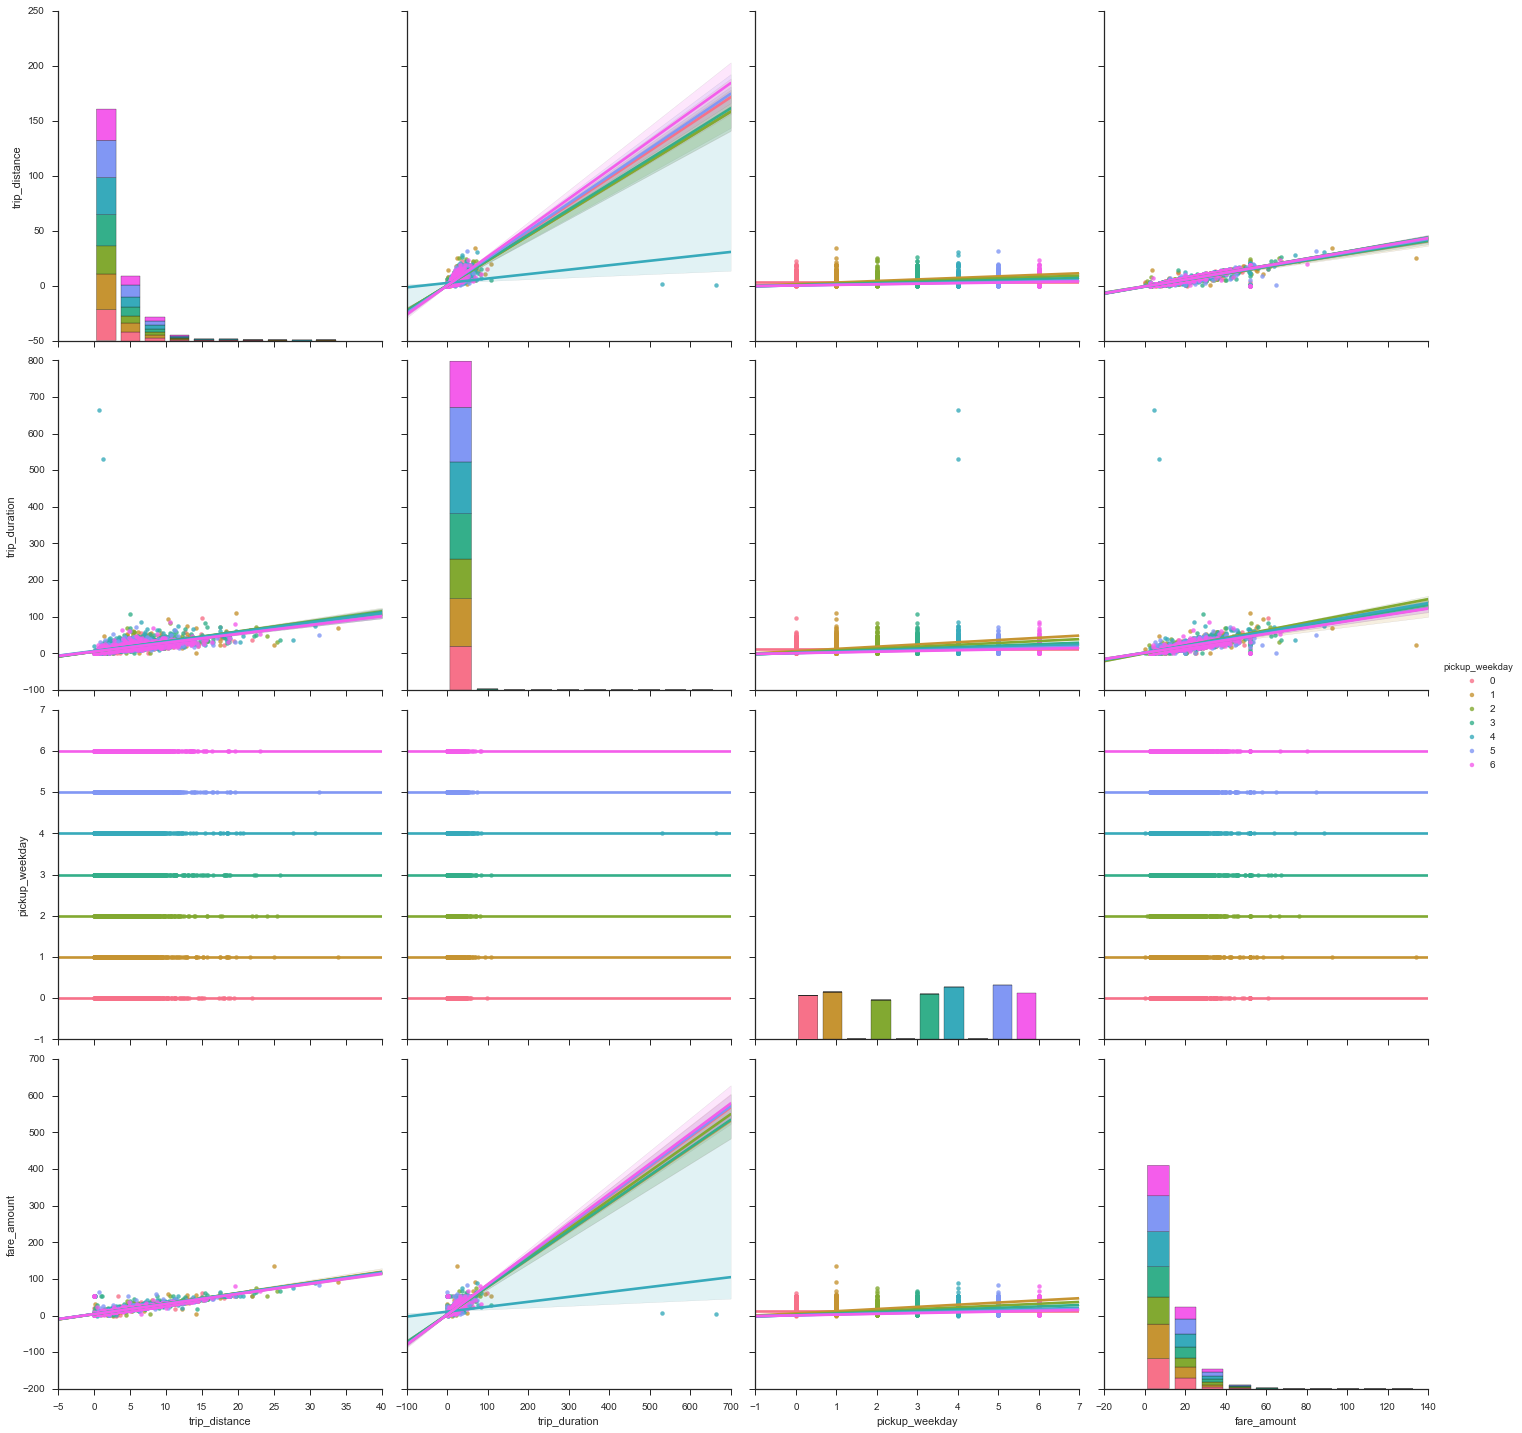

In [257]:
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["trip_duration"] = train["trip_duration"]
chart["pickup_weekday"] = train["pickup_weekday"]
chart["fare_amount"] = train["fare_amount"]

chart.sort_values(by=["trip_distance"], inplace=True)

sns.pairplot(chart, kind="reg", size=5, hue="pickup_weekday")

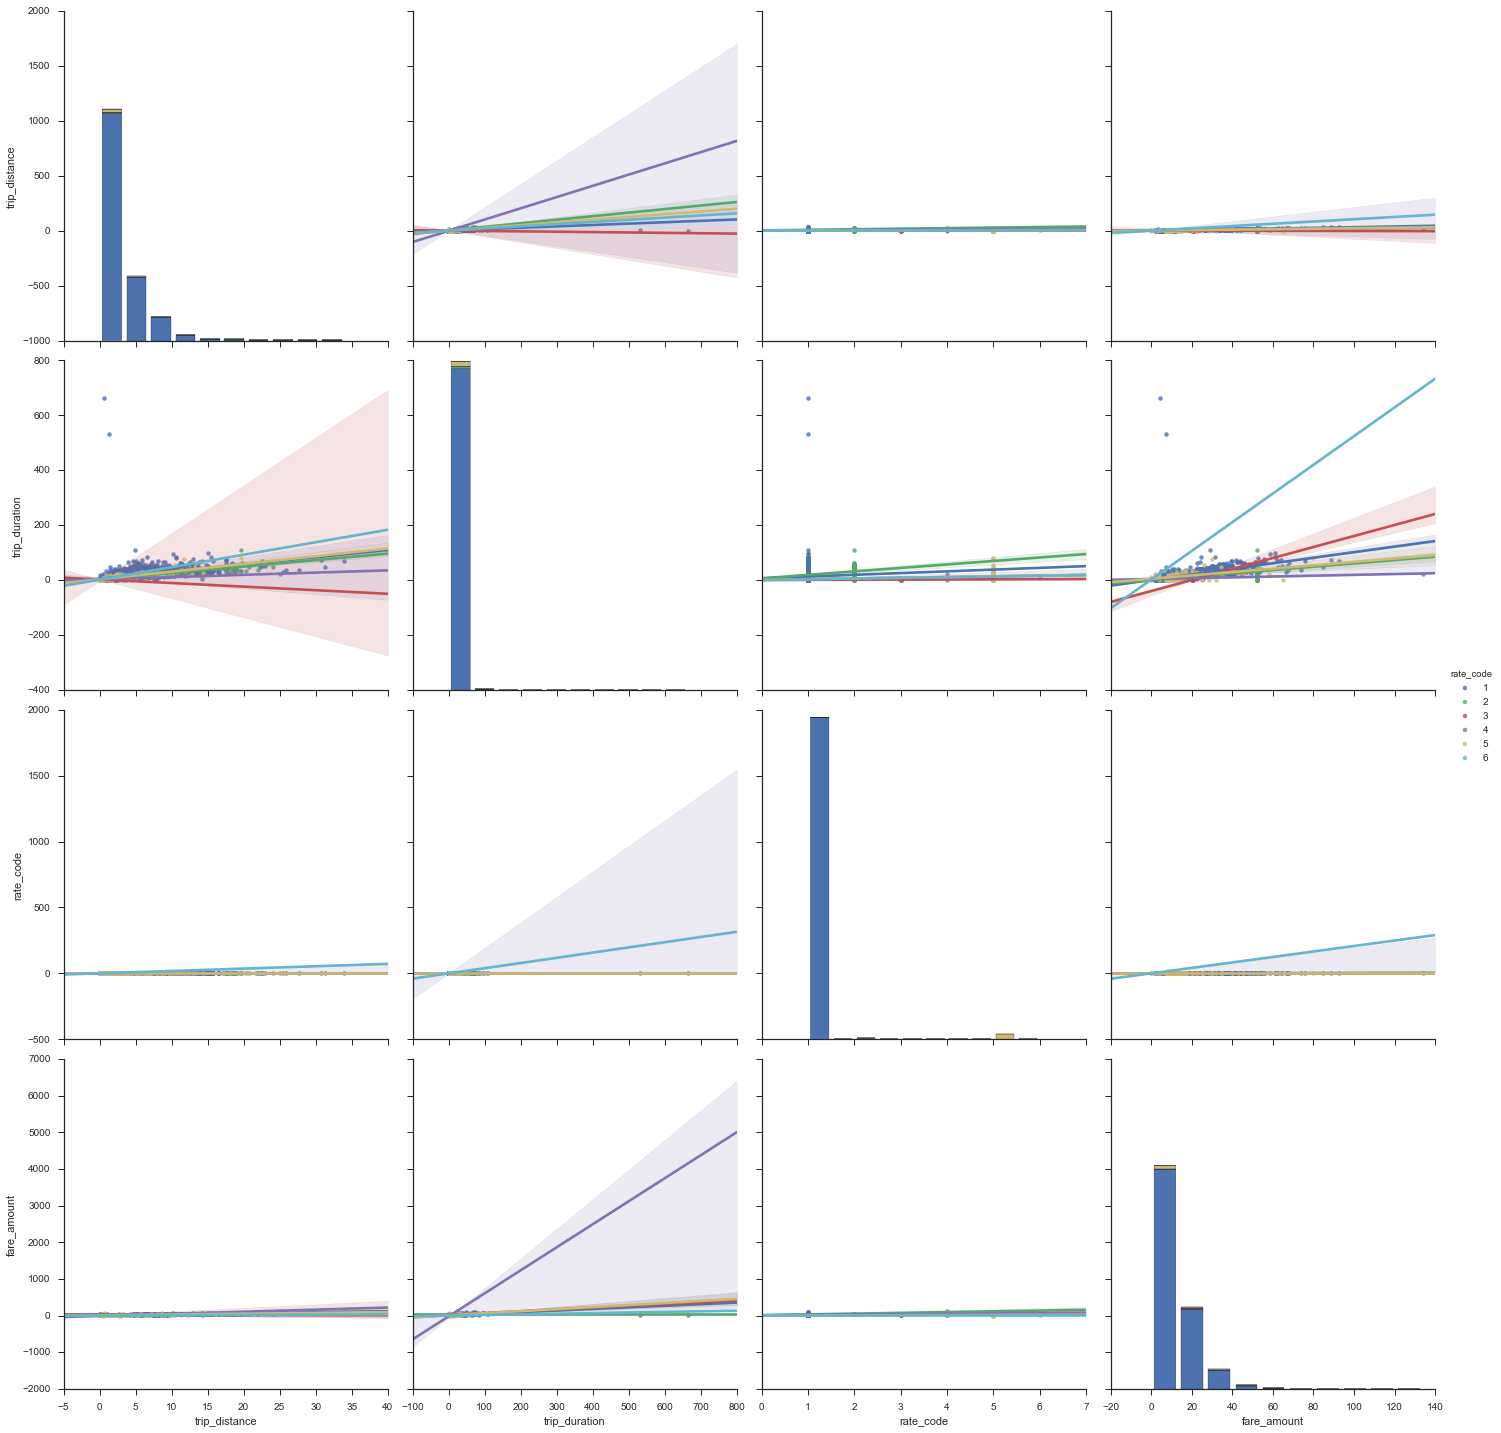

In [258]:
chart = pd.DataFrame(train["trip_distance"], index=None, columns = ["trip_distance"])
chart["trip_duration"] = train["trip_duration"]
chart["rate_code"] = train["rate_code"]
chart["fare_amount"] = train["fare_amount"]

chart.sort_values(by=["trip_distance"], inplace=True)

sns.pairplot(chart, kind="reg", size=5, hue="rate_code")

## Multivariate analysis

In [51]:
#Distance X Duration X Time of Day

trace0 = Scatter(
            x = train["trip_duration"][train["time"] == "midnight"],
            y = train["trip_distance"][train["time"] == "midnight"],
            mode = 'markers',
            name = 'midnight'
            )
trace1 = Scatter(
            x = train["trip_duration"][train["time"] == "morning"],
            y = train["trip_distance"][train["time"] == "morning"],
            mode = 'markers',
            name = 'morning'
            )
trace2 = Scatter(
            x = train["trip_duration"][train["time"] == "noon"],
            y = train["trip_distance"][train["time"] == "noon"],
            mode = 'markers',
            name = 'noon'
            )
trace3 = Scatter(
            x = train["trip_duration"][train["time"] == "afternoon"],
            y = train["trip_distance"][train["time"] == "afternoon"],
            mode = 'markers',
            name = 'afternoon'
            )
trace4 = Scatter(
            x = train["trip_duration"][train["time"] == "evening"],
            y = train["trip_distance"][train["time"] == "evening"],
            mode = 'markers',
            name = 'evening'
            )
trace5 = Scatter(
            x = train["trip_duration"][train["time"] == "night"],
            y = train["trip_distance"][train["time"] == "night"],
            mode = 'markers',
            name = 'night'
            )

data = [trace0,trace1,trace2,trace3,trace4,trace5]
iplot(data)

In [52]:
#Distance X Fare X Time of Day = to find out congestions

trace0 = Scatter(
            x = train["trip_distance"][train["time"] == "midnight"],
            y = train["fare_amount"][train["time"] == "midnight"],
            mode = 'markers',
            name = 'midnight'
            )
trace1 = Scatter(
            x = train["trip_distance"][train["time"] == "morning"],
            y = train["fare_amount"][train["time"] == "morning"],
            mode = 'markers',
            name = 'morning'
            )
trace2 = Scatter(
            x = train["trip_distance"][train["time"] == "noon"],
            y = train["fare_amount"][train["time"] == "noon"],
            mode = 'markers',
            name = 'noon'
            )
trace3 = Scatter(
            x = train["trip_distance"][train["time"] == "afternoon"],
            y = train["fare_amount"][train["time"] == "afternoon"],
            mode = 'markers',
            name = 'afternoon'
            )
trace4 = Scatter(
            x = train["trip_distance"][train["time"] == "evening"],
            y = train["fare_amount"][train["time"] == "evening"],
            mode = 'markers',
            name = 'evening'
            )
trace5 = Scatter(
            x = train["trip_distance"][train["time"] == "night"],
            y = train["fare_amount"][train["time"] == "night"],
            mode = 'markers',
            name = 'night'
            )

data = [trace0,trace1,trace2,trace3,trace4,trace5]
iplot(data)

In [53]:
#I think that we shoud remove this graph as it doesn't show anything useful

"""trace0 = Scatter(
            x = train["trip_distance"][train["same_borough"] == True],
            y = train["fare_amount"][train["same_borough"] == True],
            mode = 'markers',
            name = 'Same Borough'
            )
trace1 = Scatter(
            x = train["trip_distance"][train["same_borough"] == False],
            y = train["fare_amount"][train["time"] == False],
            mode = 'markers',
            name = 'Different Borough'
            )

data = [trace0,trace1]
iplot(data)"""

'trace0 = Scatter(\n            x = train["trip_distance"][train["same_borough"] == True],\n            y = train["fare_amount"][train["same_borough"] == True],\n            mode = \'markers\',\n            name = \'Same Borough\'\n            )\ntrace1 = Scatter(\n            x = train["trip_distance"][train["same_borough"] == False],\n            y = train["fare_amount"][train["time"] == False],\n            mode = \'markers\',\n            name = \'Different Borough\'\n            )\n\ndata = [trace0,trace1]\niplot(data)'

In [55]:
#Distance X Fare X Day of the week

trace0 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 0],
            y = train["fare_amount"][train["pickup_weekday"] == 0],
            mode = 'markers',
            name = 'monday'
            )
trace1 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 1],
            y = train["fare_amount"][train["pickup_weekday"] == 1],
            mode = 'markers',
            name = 'tuesday'
            )
trace2 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 2],
            y = train["fare_amount"][train["pickup_weekday"] == 2],
            mode = 'markers',
            name = 'wednesday'
            )
trace3 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 3],
            y = train["fare_amount"][train["pickup_weekday"] == 3],
            mode = 'markers',
            name = 'thursday'
            )
trace4 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 4],
            y = train["fare_amount"][train["pickup_weekday"] == 4],
            mode = 'markers',
            name = 'friday'
            )
trace5 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 5],
            y = train["fare_amount"][train["pickup_weekday"] == 5],
            mode = 'markers',
            name = 'saturday'
            )
trace6 = Scatter(
            x = train["trip_distance"][train["pickup_weekday"] == 6],
            y = train["fare_amount"][train["pickup_weekday"] == 6],
            mode = 'markers',
            name = 'sunday'
            )


data = [trace0,trace1,trace2,trace3,trace4,trace5,trace6]
iplot(data)

In [56]:
# Calculate the average fare per distance for each Day of the week
days = []
fare_per_dist = []

for DOTW in range(0,7):

    mon = train[train["pickup_weekday"] == DOTW]
    fare_sum = mon["fare_amount"].sum()
    dist_sum = mon["trip_distance"].sum()
    
    days.append(DOTW)
    fare_per_dist.append(fare_sum/dist_sum)
    
    print DOTW, fare_sum/dist_sum

print days
print fare_per_dist

0 4.0818259446
1 4.21211927215
2 4.10894978152
3 4.12014335731
4 4.17326986624
5 4.03052078298
6 3.93459572059
[0, 1, 2, 3, 4, 5, 6]
[4.081825944602206, 4.212119272154234, 4.108949781520768, 4.1201433573105115, 4.173269866240317, 4.030520782982343, 3.934595720590261]


In [57]:
# Plot the average fare per distance for each Day of the week


data = [go.Bar(
            x= days,
            y=fare_per_dist,
    )]

layout =  go.Layout(
    title = 'The average fare per km travelled for each day of the week',
    legend = dict(
        x=0.1,
        y=0.1
    ),

    xaxis = dict(title = 'Days'),
    yaxis = dict(title = 'Fare/Distance ratio', range = [3.5, 4.5]),
    width = 600,
    height = 500,
)

iplot({'data': data, 'layout': layout})

In [58]:
# Calculate the average speed for each Day of the week
days = []
speed = []

for DOTW in range(0,7):

    tpd = train[train["pickup_weekday"] == DOTW]
    time_sum = tpd["trip_duration"].sum()
    dist_sum = tpd["trip_distance"].sum()
    
    days.append(DOTW)
    speed.append(dist_sum/(time_sum/60))
    
    print DOTW, (dist_sum/(time_sum/60))

print days
print speed

0 14.6468850538
1 13.8899967224
2 13.9736212778
3 14.421662481
4 12.7741318949
5 14.9168397496
6 15.7950770777
[0, 1, 2, 3, 4, 5, 6]
[14.646885053808743, 13.889996722417226, 13.973621277835896, 14.42166248104035, 12.774131894935483, 14.91683974962507, 15.795077077702986]


In [59]:
# Plot the average speed for each Day of the week


data = [go.Bar(
            x= days,
            y=speed,
    )]

layout =  go.Layout(
    title = 'The average taxi speed for each day of the week',
    legend = dict(
        x=0.1,
        y=0.1
    ),

    xaxis = dict(title = 'Days'),
    yaxis = dict(title = 'Speed', range = [12, 16]),
    width = 600,
    height = 500,
)

iplot({'data': data, 'layout': layout})

In [60]:
#Duration X Fare X Day of the week

trace0 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 0],
            y = train["fare_amount"][train["pickup_weekday"] == 0],
            mode = 'markers',
            name = 'monday'
            )
trace1 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 1],
            y = train["fare_amount"][train["pickup_weekday"] == 1],
            mode = 'markers',
            name = 'tuesday'
            )
trace2 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 2],
            y = train["fare_amount"][train["pickup_weekday"] == 2],
            mode = 'markers',
            name = 'wednesday'
            )
trace3 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 3],
            y = train["fare_amount"][train["pickup_weekday"] == 3],
            mode = 'markers',
            name = 'thursday'
            )
trace4 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 4],
            y = train["fare_amount"][train["pickup_weekday"] == 4],
            mode = 'markers',
            name = 'friday'
            )
trace5 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 5],
            y = train["fare_amount"][train["pickup_weekday"] == 5],
            mode = 'markers',
            name = 'saturday'
            )
trace6 = Scatter(
            x = train["trip_duration"][train["pickup_weekday"] == 6],
            y = train["fare_amount"][train["pickup_weekday"] == 6],
            mode = 'markers',
            name = 'sunday'
            )


data = [trace0,trace1,trace2,trace3,trace4,trace5,trace6]
iplot(data)

## Conclusion of bivariate and multivariate analysis:

### 1) Trip distance has a linear relationship with fare
### 2) Trip duration has a strong correlation with trip distance so we will drop it
####   
#### 3) Passenger number, rate code, borough, pick up time and day of the week appear to have no correlation with the fare when used alone but could be useful when put together.
#### 4) Trips at night seems to be shorter and therefore cheaper.
#### 5) Fares seems to be slightly cheaper on the weekend for a given distance.
#### 6) The average speed of the taxi journey appears to be faster on the weekend (links to point 5).
#### 7) Speed seemed to be much slower on Friday but this may be due to some outliers rater than just traffic.

## 2. Motivation for feature selection: Using EDA to select features

Dropping out features that are correlated, categorical 

In [96]:
def featuresincluded (df):
    drop_list = ["rate_code","pickup_date", "pickup_time", "dropoff_time", "dropoff_weekday", "pickup_time_hour", 
           "dropoff_borough_bronx", "dropoff_borough_brooklyn", "dropoff_borough_manhattan", "dropoff_borough_queens",
           "pickup_borough_bronx", 'pickup_borough_staten island',
            "borough", "dropoff_borough", "dropoff_date", "monday", "trip_duration"]
    new_list = df.drop(drop_list, axis=1)

    """def isweekend(DOW):
        if DOW >= 5:
            return "weekend"
        else: return "weekday"""

#    new_list["dummy"] = new_list["pickup_weekday"].apply(isweekend)    
#    dummy_weekend = pd.get_dummies(new_list["dummy"], prefix="is")    
    dummy_borough = pd.get_dummies(new_list["same_borough"], prefix="same_borough_is")  
    dummy_time = pd.get_dummies(new_list["time"], prefix="time")
#    new_list = new_list.join(dummy_weekend)
    new_list = new_list.join(dummy_borough)
    new_list = new_list.join(dummy_time)
    
    drop_list2 = ["same_borough", "same_borough_is_True", "time", "time_noon", "rate_code_99"]  
    new_list = new_list.drop(drop_list2, axis=1)
    return new_list

In [97]:
df["same_borough"].head(3)

0    True
1    True
2    True
Name: same_borough, dtype: bool

In [98]:
train1 = featuresincluded (train)

In [99]:
train1.head(3)

passenger_count  trip_distance  fare_amount  extra  mta_tax  \
785532                1           9.50         28.0    0.5      0.5   
481992                1           1.27          8.5    0.0      0.5   
419362                1           1.06          5.5    0.0      0.5   

        tip_amount  tolls_amount  total_amount  pickup_weekday  rate_code_1  \
785532         0.0           0.0          29.0               5          1.0   
481992         0.0           0.0           9.0               1          1.0   
419362         0.0           0.0           6.0               6          1.0   

        rate_code_2  rate_code_3  rate_code_4  rate_code_5  rate_code_6  \
785532          0.0          0.0          0.0          0.0          0.0   
481992          0.0          0.0          0.0          0.0          0.0   
419362          0.0          0.0          0.0          0.0          0.0   

        tuesday  wednesday  thursday  friday  saturday  sunday  \
785532      0.0        0.0       0.0     0.0       1.0     0.0   
481992      1.0        0.0       0.0     0.0       0.0     0.0   
419362      0.0        0.0       0.0     0.0       0.0     1.0   

        dropoff_borough_staten island  pickup_borough_brooklyn  \
785532                            0.0                      0.0   
481992                            0.0                      0.0   
419362                            0.0                      0.0   

        pickup_borough_manhattan  pickup_borough_queens  \
785532                       0.0                    1.0   
481992                       0.0                    1.0   
419362                       1.0                    0.0   

        same_borough_is_False  time_afternoon  time_evening  time_midnight  \
785532                    1.0             0.0           0.0            0.0   
481992                    0.0             0.0           1.0            0.0   
419362                    0.0             1.0           0.0            0.0   

        time_morning  time_night  
785532           0.0         1.0  
481992           0.0         0.0  
419362           0.0         0.0

## 3. Checking whether the preconditions for linear regression have been met

### Assumptions of Linear Regression

### Variables are normally distributed 


### Assumption of a linear relationship between the independent and dependent variable(s).

### Assumption of homoscedasticity
#### Checked during EDA

### Independence of ... the Independent Variable 
#### Checked during EDA
#### Used a heat map to check correlation

### Variables are measured without error (reliably)
#### Using large data set and removed unreliable data

### Independence of the Error Terms
#### We will plot the residuals once we have a model

## More Feature Selection: Using F test and P values

In [100]:
#splitting X & y
y_list = ["fare_amount","tolls_amount" ,"extra", "mta_tax", "tip_amount", "total_amount"]  
Xtrain = train1.drop(y_list, axis=1)
yset = train1[y_list]

In [101]:
Xtrain.head(3)

passenger_count  trip_distance  pickup_weekday  rate_code_1  \
785532                1           9.50               5          1.0   
481992                1           1.27               1          1.0   
419362                1           1.06               6          1.0   

        rate_code_2  rate_code_3  rate_code_4  rate_code_5  rate_code_6  \
785532          0.0          0.0          0.0          0.0          0.0   
481992          0.0          0.0          0.0          0.0          0.0   
419362          0.0          0.0          0.0          0.0          0.0   

        tuesday  wednesday  thursday  friday  saturday  sunday  \
785532      0.0        0.0       0.0     0.0       1.0     0.0   
481992      1.0        0.0       0.0     0.0       0.0     0.0   
419362      0.0        0.0       0.0     0.0       0.0     1.0   

        dropoff_borough_staten island  pickup_borough_brooklyn  \
785532                            0.0                      0.0   
481992                            0.0                      0.0   
419362                            0.0                      0.0   

        pickup_borough_manhattan  pickup_borough_queens  \
785532                       0.0                    1.0   
481992                       0.0                    1.0   
419362                       1.0                    0.0   

        same_borough_is_False  time_afternoon  time_evening  time_midnight  \
785532                    1.0             0.0           0.0            0.0   
481992                    0.0             0.0           1.0            0.0   
419362                    0.0             1.0           0.0            0.0   

        time_morning  time_night  
785532           0.0         1.0  
481992           0.0         0.0  
419362           0.0         0.0

In [102]:
from sklearn import feature_selection as fs

def f_regression_feature_selection(input, response):    
    return fs.univariate_selection.f_regression(input, response) 

In [103]:
#selecting features
y = yset["fare_amount"]
f_regression_feature_selection(Xtrain, y)

(array([  3.84138797e+00,   6.80832805e+04,   9.51011555e+00,
          4.09642819e+02,   1.16910537e+03,   5.16950286e+00,
          4.63111248e+01,   1.19342397e+01,   1.25231710e+00,
          9.62809202e+00,   3.12372346e-01,   6.01630156e+00,
          3.40996738e-01,   2.19716531e+00,   2.29483568e+00,
          6.56717389e+01,   2.28273342e+01,   1.77589448e+00,
          3.99088814e-01,   2.70297204e+03,   4.10487338e+00,
          9.88186855e+00,   2.23054244e+00,   2.27426706e+00,
          1.47413973e+00]),
 array([  5.00298491e-002,   0.00000000e+000,   2.04899351e-003,
          2.65826211e-089,   2.00569691e-242,   2.30079019e-002,
          1.06674153e-011,   5.53402706e-004,   2.63137269e-001,
          1.92157909e-003,   5.76240572e-001,   1.41912799e-002,
          5.59267624e-001,   1.38296310e-001,   1.29836559e-001,
          5.94946724e-016,   1.79749414e-006,   1.82684639e-001,
          5.27574650e-001,   0.00000000e+000,   4.27862942e-002,
          1.67403584e

In [104]:
"""data = pd.DataFrame(Xtrain,y).reset_index()"""

'data = pd.DataFrame(Xtrain,y).reset_index()'

In [105]:
"""g = sns.PairGrid(data, diag_sharey=False)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g= g.map_upper(plt.scatter)
g= g.map_diag(sns.kdeplot, lw=3, legend=False)"""

'g = sns.PairGrid(data, diag_sharey=False)\ng = g.map_lower(sns.kdeplot, cmap="Blues_d")\ng= g.map_upper(plt.scatter)\ng= g.map_diag(sns.kdeplot, lw=3, legend=False)'

In [106]:
# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(Xtrain,y)[0] < 10)

17

In [107]:
# Which column are we talking about?
select = f_regression_feature_selection(Xtrain,y)[0] < 10
Xtrain.columns[select]

Index([u'passenger_count', u'pickup_weekday', u'rate_code_3', u'rate_code_6',
       u'tuesday', u'wednesday', u'thursday', u'friday', u'saturday',
       u'sunday', u'pickup_borough_manhattan', u'pickup_borough_queens',
       u'time_afternoon', u'time_evening', u'time_midnight', u'time_morning',
       u'time_night'],
      dtype='object')

In [108]:
# How many features don't meet the p value threshold?
sum(f_regression_feature_selection(Xtrain,y)[1] > 0.05)

11

In [109]:
select = f_regression_feature_selection(Xtrain,y)[1] > 0.05
Xtrain.columns[select]

Index([u'passenger_count', u'rate_code_6', u'wednesday', u'friday',
       u'saturday', u'sunday', u'pickup_borough_manhattan',
       u'pickup_borough_queens', u'time_midnight', u'time_morning',
       u'time_night'],
      dtype='object')

In [110]:
# Sort the features based on their statistical significance 
ps = f_regression_feature_selection(Xtrain,y)[1]

p_score = zip(Xtrain.columns, ps)
ranked_p = sorted(p_score, key=lambda x:x[1])
ranked_p 
#the lower the better!

[('trip_distance', 0.0),
 ('same_borough_is_False', 0.0),
 ('rate_code_2', 2.0056969139734944e-242),
 ('rate_code_1', 2.6582621060844279e-89),
 ('dropoff_borough_staten island', 5.9494672379200599e-16),
 ('rate_code_4', 1.0667415251584457e-11),
 ('pickup_borough_brooklyn', 1.7974941436209636e-06),
 ('rate_code_5', 0.00055340270620465599),
 ('time_evening', 0.0016740358379382528),
 ('tuesday', 0.0019215790883003727),
 ('pickup_weekday', 0.0020489935068109346),
 ('thursday', 0.014191279859278956),
 ('rate_code_3', 0.023007901852981197),
 ('time_afternoon', 0.042786294249331169),
 ('passenger_count', 0.050029849116538412),
 ('sunday', 0.129836559360163),
 ('time_morning', 0.13156889372345676),
 ('time_midnight', 0.13533789359554069),
 ('saturday', 0.13829631029276854),
 ('pickup_borough_manhattan', 0.18268463886009306),
 ('time_night', 0.22472234888090739),
 ('rate_code_6', 0.26313726882525329),
 ('pickup_borough_queens', 0.52757465027781802),
 ('friday', 0.55926762401040275),
 ('wednesda

In [111]:
test = df.sample(frac=0.01)
xtest = featuresincluded (test)
xtest.drop(y_list, axis=1, inplace=True)
ytest = test["fare_amount"]

In [112]:
xtest.head(3)

passenger_count  trip_distance  pickup_weekday  rate_code_1  \
1022618                1           3.63               6          1.0   
1110120                1           0.90               1          1.0   
635687                 1           1.17               4          1.0   

         rate_code_2  rate_code_3  rate_code_4  rate_code_5  rate_code_6  \
1022618          0.0          0.0          0.0          0.0          0.0   
1110120          0.0          0.0          0.0          0.0          0.0   
635687           0.0          0.0          0.0          0.0          0.0   

         tuesday  wednesday  thursday  friday  saturday  sunday  \
1022618      0.0        0.0       0.0     0.0       0.0     1.0   
1110120      1.0        0.0       0.0     0.0       0.0     0.0   
635687       0.0        0.0       0.0     1.0       0.0     0.0   

         dropoff_borough_staten island  pickup_borough_brooklyn  \
1022618                            0.0                      0.0   
1110120                            0.0                      1.0   
635687                             0.0                      0.0   

         pickup_borough_manhattan  pickup_borough_queens  \
1022618                       1.0                    0.0   
1110120                       0.0                    0.0   
635687                        1.0                    0.0   

         same_borough_is_False  time_afternoon  time_evening  time_midnight  \
1022618                    0.0             0.0           1.0            0.0   
1110120                    0.0             0.0           1.0            0.0   
635687                     0.0             0.0           0.0            1.0   

         time_morning  time_night  
1022618           0.0         0.0  
1110120           0.0         0.0  
635687            0.0         0.0

## 4. Modelling for taxi fare: 3 models

## Modelling by adding features

In [113]:
# Let's first build univariate models to see how well each individual features performs
scores = []
for feat, score in ranked_p:
    est = Ridge() #initiate ridge model
    X = [[x] for x in Xtrain[feat]]
    Xt = [[x] for x in xtest[feat]]
    est.fit(X,y)
    scores.append(est.score(Xt,ytest))

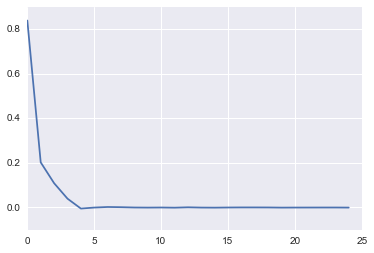

In [114]:
# Drop of R^2 with strong to weakest features
plt.plot(range(len(scores)), scores)
#xaxis is the Xth feature

In [115]:
# Now let's build models which cummatively look well combinations of features performs
scores = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xtrain[feat]]
        Xt = [[x] for x in xtest[feat]]
    else:
        X = Xtrain[feats]
        Xt = xtest[feats]
    est.fit(X, y)
    scores.append(est.score(Xt,ytest))

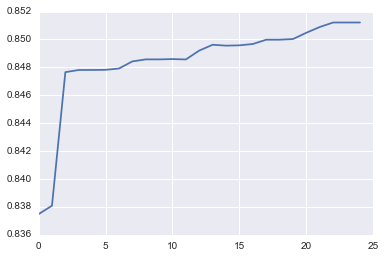

In [116]:
# Looking at how well the features perform as add one each time
plt.plot(range(len(scores)), scores)

In [117]:
p_features = [x[0] for x in ranked_p][0:3]
#p_features.append([x[0] for x in ranked_p][5])
#p_features.append([x[0] for x in ranked_p][6])
p_features

['trip_distance', 'same_borough_is_False', 'rate_code_2']

## Modelling by taking away features

In [118]:
#Recursive feature elimination
stand_Xtrain = (Xtrain - Xtrain.mean()) / Xtrain.std()
from sklearn.feature_selection import RFE
# Create the RFE object and rank each features
est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1) #pick one feature and drop one feature at a time, 
#n_feature_to_select is looking for the 1st one, if set to 5, it leaves you with 5 , 
#but you don't know which is the best
rfe.fit(stand_Xtrain, y)
ranking = rfe.ranking_
scores = zip(Xtrain.columns,ranking)
scores = sorted(scores, key=lambda x:x[1])

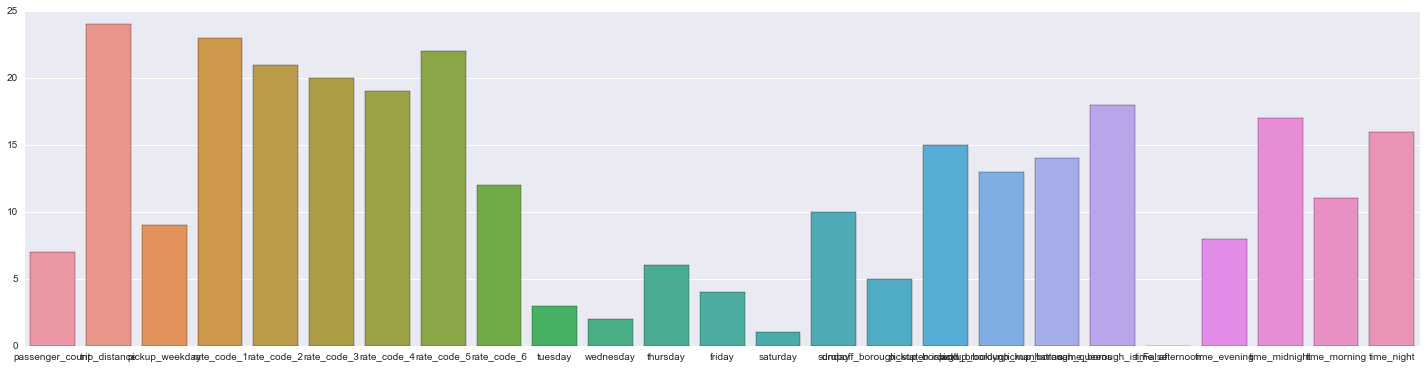

In [119]:
# Feature Importance 
plt.figure(figsize=(25, 6))
#best rank is 1, for visual representation purpose, we do 25-, i.e. weight is the best
sns.barplot(Xtrain.columns, 25 - ranking);

In [120]:
rfe_features = [x[0] for x in scores][:5]
print rfe_features

['trip_distance', 'rate_code_1', 'rate_code_5', 'rate_code_2', 'rate_code_3']


In [121]:
X_rfe = Xtrain[rfe_features]
Xt = xtest[rfe_features]
est.fit(X_rfe, y).score(Xt,ytest)

0.84793151911613762

## Modelling by hand picking features

In [122]:
handpicked_features = [x[0] for x in ranked_p][0:3]
handpicked_features.append([x[0] for x in ranked_p][5])

In [123]:
X_handpicked = Xtrain[handpicked_features]
Xt = xtest[handpicked_features]
est.fit(X_handpicked, y).score(Xt,ytest)

0.84767335137042188

## Comparing our models

In [124]:
scores = []
coef = []
constant = []

for feats in [ p_features, rfe_features, handpicked_features]:
    est = Ridge()
    X = Xtrain[feats]
    Xt = xtest[feats]
    scores.append(est.fit(X, y).score(Xt,ytest))
    coef.append(est.fit(X, y).coef_)
    constant.append(est.fit(X, y).intercept_)

print 'Adding features model score:', scores[0]
print "coefficients:", coef[0], "constant:", constant[0]
print p_features
print ""
print 'Taking away features (RFE) model score:', scores[1] 
print "coefficients:", coef[1], "constant:", constant[1]
print rfe_features
print ""
print 'Handpicked features model score:', scores[2]
print "coefficients:", coef[2], "constant:", constant[2]
print handpicked_features

Adding features model score: 0.847659240624
coefficients: [  2.70952426   0.59232908  13.08919046] constant: 4.0345209851
['trip_distance', 'same_borough_is_False', 'rate_code_2']

Taking away features (RFE) model score: 0.847931519116
coefficients: [ 2.74671398 -8.08557929 -8.00278498  5.09344203  6.63926284] constant: 12.1023556028
['trip_distance', 'rate_code_1', 'rate_code_5', 'rate_code_2', 'rate_code_3']

Handpicked features model score: 0.84767335137
coefficients: [  2.70586787   0.60148841  13.12295611  11.75718096] constant: 4.04027259124
['trip_distance', 'same_borough_is_False', 'rate_code_2', 'rate_code_4']


### Looking at lambda (alpha)

In [125]:
model_name = ["Adding Features","Taking away features(RFE)", "Handpicked features model"]
i = 0
for feats in [ p_features, rfe_features, handpicked_features]:
    print model_name[i]
    for a in [0, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
        est = Ridge(alpha = a)
        X = Xtrain[feats]
        Xt = xtest[feats]
        print a, ":" , est.fit(X,y).score(Xt,ytest)
    print ""
    i = i+1

Adding Features
0 : 0.847626738713
0.1 : 0.84763045266
1 : 0.847659240624
2 : 0.847682134041
5 : 0.847702759934
10 : 0.847620906898
20 : 0.847226448976
50 : 0.84570137389
100 : 0.843794206735
200 : 0.841814160619
500 : 0.839876081465
1000 : 0.838968081738

Taking away features(RFE)
0 : 0.847807276565
0.1 : 0.847826948564
1 : 0.847931519116
2 : 0.847986857016
5 : 0.848038270842
10 : 0.84799944822
20 : 0.847772137121
50 : 0.846762597321
100 : 0.845203131424
200 : 0.843221039467
500 : 0.84081418069
1000 : 0.839469761054

Handpicked features model
0 : 0.847643578317
0.1 : 0.847646960732
1 : 0.84767335137
2 : 0.847694408037
5 : 0.8477118717
10 : 0.847627518556
20 : 0.847230793106
50 : 0.845703387312
100 : 0.843795133662
200 : 0.84181452229
500 : 0.839876148259
1000 : 0.838968068983



### Plotting residuals as a function of the actual fare

In [126]:
y_values = pd.DataFrame(ytest)

In [127]:
est = Ridge()
X = Xtrain[handpicked_features]
Xt = xtest[handpicked_features]

y_values["predict_fare_amount"] = est.fit(X,y).predict(Xt)

In [128]:
y_values.head(3)

fare_amount  predict_fare_amount
1022618         17.5            13.862573
1110120          7.0             6.475554
635687           5.5             7.206138

In [129]:
y_values["residuals"]= y_values['fare_amount'] - y_values["predict_fare_amount"]

In [130]:
y_values.sort_values(by='fare_amount')
trace = Scatter(
        x = y_values['fare_amount'],
        y = y_values["residuals"],
        mode = "markers")

data = [trace]

py.iplot(data)

## Comparing our model to a simple linear model with just distance as a feature

In [131]:
distance = [x[0] for x in ranked_p][0]
X_dist = pd.DataFrame(Xtrain[distance])
Xt = pd.DataFrame(xtest[distance])

In [132]:
est.fit(X_dist, y).score(Xt,ytest)

0.83748018337561814

## Model score if we predict the total amount rather than fare amount (it includes tolls etc.)

Adding features model score: 0.871935507142
coefficients: [  2.77601912   1.00896044  14.8517857 ] constant: 4.74083829459
['trip_distance', 'same_borough_is_False', 'rate_code_2']

Taking away features (RFE) model score: 0.871240731253
coefficients: [ 2.84076737 -8.39749292 -9.03773225  6.47300576  6.02124444] constant: 13.1258295277
['trip_distance', 'rate_code_1', 'rate_code_5', 'rate_code_2', 'rate_code_3']

Handpicked features model score: 0.871981641693
coefficients: [  2.77214727   1.01865952  14.88754111  12.45001557] constant: 4.74692883502
['trip_distance', 'same_borough_is_False', 'rate_code_2', 'rate_code_4']

#### This gave a slightly higher score but the residuals as a function of total fare looked very similar.

## 5. Evaluation of model's strengths and weaknesses

## Strengths
### 1) All three models score pretty well against our test data : )
### 2) All models perform better than just using the feature distance : )
## Weaknesses
### 1) The residuals show that our model is not so good as the fare amount gets higher, this might be due to traffic which is hard to take in to consideration becuase it is factored into duration but this highly correated to distance. We tried to account for traffic with the time of day but this did not account for all traffic : (